In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt

In [2]:
Gamma = 2400 # Kg/m^3
E = 20000000000 # Modulo de elasticidad en Pa
Vp = math.sqrt(E/Gamma) # Velocidad de ondas de corte s^(-1)*m
Vs = 500 # Velocidad de propagación de las ondas de corte en el terreno(m/s)
L = 6 # Longitud del pilote (m)
k = 40*10*(100**3) #Rigidez a la fricción del suelo(N/m^3)
c = 0.01*10*(100*3) #Coeficiente de amortiguamiento del suelo (N*sec/m^3)
K = (50*E*math.pi*(0.4**2)*Vs)/(4*L*Vp) # Rigidez de la punta del pilote(N/m)
C = K*0.026*L/Vs # Coeficiente de amortiguamiento de la punta del pilote(N/(m*s^(-1)))


n_L = 100 # numero de segnmentos del pilote
c_sigma = math.sqrt(E/Gamma) # velocidad de onda de tension en m/s
Delta_x = L/n_L # longitud del segmento
Delta_t = Delta_x/c_sigma
n_p = 3*(L/c_sigma)*(1/Delta_t)

u = np.zeros((n_L+1, int(n_p)+1))
up = np.zeros((n_L+1, int(n_p)+1))
u_prima = np.zeros((n_L+1, int(n_p)+1))

I = [0]

In [3]:
def p(t):
    global res
    if t<0.0001:
        res = 500000*t/0.0001
    elif 0.0001<t<=0.0006:
        res = 500000
    elif 0.0006<t<=0.0007:
        res = 500000*(1-((t-0.0006)/0.0001))
    elif t>0.0007:
        res = 0
    return res 

In [4]:
import random

def diametro():

    diam = []
    pos = random.randint(0,10)
    estriccion = random.randint(75,100)
    perturbacion = random.randint(3,8)
    lim1 = pos-perturbacion
    lim2 = pos+perturbacion
    start = 10*pos
    end = 10*pos + 10

    for i in range(0, 100+1):
             
        if i in range(start, end):
            diam.append(0.4*estriccion/100)
        else:
            diam.append(0.4)
    
    return diam

def eventos(cantidad_eventos):
    
    eventos = []
    
    for j in range(0,cantidad_eventos):
        daño = diametro()
        eventos.append(daño)
    
    return eventos

In [5]:
def funcion_1(phi):
    xi = [round(i*Delta_x, 5) for i in range(0,n_L+1)]
    fii = phi
    ki = [k for i in range(0,n_L+1)]
    ci = [c for i in range(0,n_L+1)]
    ai = [math.sqrt(Gamma*E)*(fii[i]**2) for i in range(0,n_L+1)]
    bi = [Gamma*(fii[i]**2) for i in range(0,n_L+1)]
    fi_prima = [(fii[i+1]-fii[i])/(xi[i+1]-xi[i]) for i in range(0,n_L)]
    fi_prima.insert(n_L+1,0)
    
    return xi, fii, ki, ci, ai, bi, fi_prima

In [6]:
from numpy.linalg import det, inv

def funcion_2(phi):
    
    xi, fii, ki, ci, ai, bi, fi_prima = funcion_1(phi)
    
    for i in range(1, n_L):
        a11 = ai[i-1]+ai[i]+2*E*fii[i]*fi_prima[i]*Delta_t
        a12 = -(bi[i-1]+bi[i])-4*ci[i]*fii[i]*Delta_t
        a13 = -4*ki[i]*fii[i]*Delta_t
        a21 = -(ai[i-1] + ai[i]) + 2*E*fii[i]*fi_prima[i]*Delta_t
        a22 = -(bi[i] + bi[i+1])-4*ci[i]*fii[i]*Delta_t
        a23 = a13
        a31 = 0
        a32 = -Delta_t/2
        a33 = 1

        matrix = inv([[a11, a12, a13], [a21, a22, a23], [a31, a32, a33]])
        I.append(matrix)
    
    return I

In [7]:
def funcion_3(phi):
    
    xi, fii, ki, ci, ai, bi, fi_prima = funcion_1(phi)
    
    a210 = -(ai[0]+ai[1])
    a220 = -(bi[0]+bi[1])

    I0 = inv([[(1-(4*(ci[0]*fii[0]/a220)*Delta_t)), -(4*(ki[0]*fii[0]/a220)*Delta_t)],
              [-Delta_t/2, 1]])
    
    return a210, a220, I0

In [8]:
def funcion_4(phi):
    
    xi, fii, ki, ci, ai, bi, fi_prima = funcion_1(phi)

    a11 = ai[n_L-1]+ai[n_L]+2*E*fii[n_L]*fi_prima[n_L]*Delta_t
    a12 = -(bi[n_L-1]+bi[n_L])-4*ci[n_L]*fii[n_L]*Delta_t
    a13 = -4*ki[n_L]*fii[n_L]*Delta_t
    a21 = ((math.pi)/4)*((fii[n_L])**2)*E
    a22 = C
    a23 = K
    a31 = -Delta_x/2
    a32 = -Delta_t/2
    a33 = 1

    In = inv([[a11, a12, a13], [a21, a22, a23], [a31, a32, a33]])

    return In

In [9]:
def e(x, u, u_prima, up, phi):
    
    xi, fii, ki, ci, ai, bi, fi_prima = funcion_1(phi)
    
    e = (2*E*fii[x]*fi_prima[x]*u_prima)-(4*ci[x]*fii[x]*up)-(4*ki[x]*fii[x]*u) 
    return e

In [10]:
def funcion_5(phi):
    
    xi, fii, ki, ci, ai, bi, fi_prima = funcion_1(phi)

    for j in range(0, int(n_p)+1):

        c = j*Delta_t
        u_prima[0][j] = -4*(p((c)))/(math.pi*E*(fii[0]**2))

        for i in range(0, n_L+1):
            u[i][j] = 0
            up[i][j] = 0

            if i != 0:
                u_prima[i][j] = 0
                
    return u_prima, u, up

In [11]:
def funcion_6(phi):
    
    xi, fii, ki, ci, ai, bi, fi_prima = funcion_1(phi)
    I = funcion_2(phi)
    a210, a220, I0 = funcion_3(phi)    
    In = funcion_4(phi)
    u_prima, u, up = funcion_5(phi)
    
    
    for j in range(1, int(n_p)+1):
        for i in np.arange(int((1+((-1)**(j+1)))/2),
                        min(j,n_L+1),
                        2):

            if i != 0:
                eA = e((i-1), u[i-1][j-1], u_prima[i-1][j-1], up[i-1][j-1], phi)

            if i != n_L:
                eB = e(i+1, u[i+1][j-1], u_prima[i+1][j-1], up[i+1][j-1], phi)

            if i == 0:
                q4 = up[1][j-1]-(1/a220)*(a210*(u_prima[0][j]-u_prima[1][j-1])+eB*Delta_t)-((2*E*fii[0]*fi_prima[0]*u_prima[0][j]*Delta_t)/a220)
                q5 = u[1][j-1]-(Delta_x/2)*(u_prima[0][j]+u_prima[1][j-1])+(Delta_t/2)*up[1][j-1]
                up[0][j] = I0[0][0]*q4+I0[0][1]*q5
                u[0][j] = I0[1][0]*q4+I0[1][1]*q5


            if i == n_L:
                q1 = (ai[i-1]+ai[i])*u_prima[i-1][j-1]-(bi[i-1]+bi[i])*up[i-1][j-1]-eA*Delta_t
                q2 = 0
                q3 = u[i-1][j-1]+(Delta_x/2)*u_prima[i-1][j-1]+(Delta_t/2)*up[i-1][j-1]
                u_prima[i][j] = In[0][0]*q1+In[0][1]*q2+In[0][2]*q3
                up[i][j] = In[1][0]*q1+In[1][1]*q2+In[1][2]*q3
                u[i][j] = In[2][0]*q1+In[2][1]*q2+In[2][2]*q3

            if i != 0 and i != n_L:
                q1 = (ai[i-1]+ai[i])*u_prima[i-1][j-1]-(bi[i-1]+bi[i])*up[i-1][j-1]-eA*Delta_t
                q2 = -(ai[i]+ai[i+1])*u_prima[i+1][j-1]-(bi[i]+bi[i+1])*up[i+1][j-1]-eB*Delta_t
                q3 = ((u[i-1][j-1]+u[i+1][j-1])/2)+(Delta_x/4)*(u_prima[i-1][j-1]-u_prima[i+1][j-1])+(Delta_t/4)*(up[i-1][j-1]+up[i+1][j-1])
                u_prima[i][j] = I[i][0][0]*q1+I[i][0][1]*q2+I[i][0][2]*q3
                up[i][j] = I[i][1][0]*q1+I[i][1][1]*q2+I[i][1][2]*q3
                u[i][j] = I[i][2][0]*q1+I[i][2][1]*q2+I[i][2][2]*q3
                
    return up

# Generating dataset

### Functions inputs/outputs

In [12]:
def generate_dataset(cantidad_eventos):

    eventos_de_daño = eventos(cantidad_eventos)

    red_input = []
    red_output = eventos_de_daño

    for i in range(0, cantidad_eventos):
        daño = eventos_de_daño[i]
        up = funcion_6(daño)[0]
        red_input.append(up)
        
    return red_input, red_output

In [13]:
red_input, red_output = generate_dataset(10)

In [14]:
red_input = np.array(red_input)
red_output = np.array(red_output)

In [15]:
import pandas as pd

df_red_output = pd.DataFrame(data=red_output[:,:])
df_red_input = pd.DataFrame(data=red_input[:,:])

### Dataframes

In [16]:
df_red_output

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,100
0,0.400,0.400,0.400,0.400,0.400,0.400,0.400,0.400,0.400,0.400,...,0.4,0.4,0.4,0.4,0.4,0.4,0.4,0.4,0.4,0.4
1,0.400,0.400,0.400,0.400,0.400,0.400,0.400,0.400,0.400,0.400,...,0.4,0.4,0.4,0.4,0.4,0.4,0.4,0.4,0.4,0.4
2,0.400,0.400,0.400,0.400,0.400,0.400,0.400,0.400,0.400,0.400,...,0.4,0.4,0.4,0.4,0.4,0.4,0.4,0.4,0.4,0.4
3,0.400,0.400,0.400,0.400,0.400,0.400,0.400,0.400,0.400,0.400,...,0.4,0.4,0.4,0.4,0.4,0.4,0.4,0.4,0.4,0.4
4,0.400,0.400,0.400,0.400,0.400,0.400,0.400,0.400,0.400,0.400,...,0.4,0.4,0.4,0.4,0.4,0.4,0.4,0.4,0.4,0.4
5,0.400,0.400,0.400,0.400,0.400,0.400,0.400,0.400,0.400,0.400,...,0.4,0.4,0.4,0.4,0.4,0.4,0.4,0.4,0.4,0.4
6,0.312,0.312,0.312,0.312,0.312,0.312,0.312,0.312,0.312,0.312,...,0.4,0.4,0.4,0.4,0.4,0.4,0.4,0.4,0.4,0.4
7,0.400,0.400,0.400,0.400,0.400,0.400,0.400,0.400,0.400,0.400,...,0.4,0.4,0.4,0.4,0.4,0.4,0.4,0.4,0.4,0.4
8,0.328,0.328,0.328,0.328,0.328,0.328,0.328,0.328,0.328,0.328,...,0.4,0.4,0.4,0.4,0.4,0.4,0.4,0.4,0.4,0.4
9,0.400,0.400,0.400,0.400,0.400,0.400,0.400,0.400,0.400,0.400,...,0.4,0.4,0.4,0.4,0.4,0.4,0.4,0.4,0.4,0.4


In [17]:
df_red_input

,0,1,2,3,4,5,6,7,8,9,...,291,292,293,294,295,296,297,298,299,300
0,0.0,0.0,0.238646,0.0,0.476948,0.0,0.572718,0.0,0.570864,0.0,...,0.0,-3.515877e+31,0.0,-5.040008e+31,0.0,-6.715262e+31,0.0,-9.098387e+31,0.0,-1.265231e+32
1,0.0,0.0,0.238646,0.0,0.476948,0.0,0.572718,0.0,0.570864,0.0,...,0.0,-3.515877e+31,0.0,-5.040008e+31,0.0,-6.715262e+31,0.0,-9.098387e+31,0.0,-1.265231e+32
2,0.0,0.0,0.238646,0.0,0.476948,0.0,0.572718,0.0,0.570864,0.0,...,0.0,-3.515877e+31,0.0,-5.040008e+31,0.0,-6.715262e+31,0.0,-9.098387e+31,0.0,-1.265231e+32
3,0.0,0.0,0.238646,0.0,0.476948,0.0,0.572718,0.0,0.570864,0.0,...,0.0,-3.515877e+31,0.0,-5.040008e+31,0.0,-6.715262e+31,0.0,-9.098387e+31,0.0,-1.265231e+32
4,0.0,0.0,0.238646,0.0,0.476948,0.0,0.572718,0.0,0.570864,0.0,...,0.0,-3.515877e+31,0.0,-5.040008e+31,0.0,-6.715262e+31,0.0,-9.098387e+31,0.0,-1.265231e+32
5,0.0,0.0,0.238646,0.0,0.476948,0.0,0.572718,0.0,0.570864,0.0,...,0.0,-3.515877e+31,0.0,-5.040008e+31,0.0,-6.715262e+31,0.0,-9.098387e+31,0.0,-1.265231e+32
6,0.0,0.0,0.238646,0.0,0.476948,0.0,0.572718,0.0,0.570864,0.0,...,0.0,-3.515877e+31,0.0,-5.040008e+31,0.0,-6.715262e+31,0.0,-9.098387e+31,0.0,-1.265231e+32
7,0.0,0.0,0.238646,0.0,0.476948,0.0,0.572718,0.0,0.570864,0.0,...,0.0,-3.515877e+31,0.0,-5.040008e+31,0.0,-6.715262e+31,0.0,-9.098387e+31,0.0,-1.265231e+32
8,0.0,0.0,0.238646,0.0,0.476948,0.0,0.572718,0.0,0.570864,0.0,...,0.0,-3.515877e+31,0.0,-5.040008e+31,0.0,-6.715262e+31,0.0,-9.098387e+31,0.0,-1.265231e+32
9,0.0,0.0,0.238646,0.0,0.476948,0.0,0.572718,0.0,0.570864,0.0,...,0.0,-3.515877e+31,0.0,-5.040008e+31,0.0,-6.715262e+31,0.0,-9.098387e+31,0.0,-1.265231e+32


### Visualization of each event

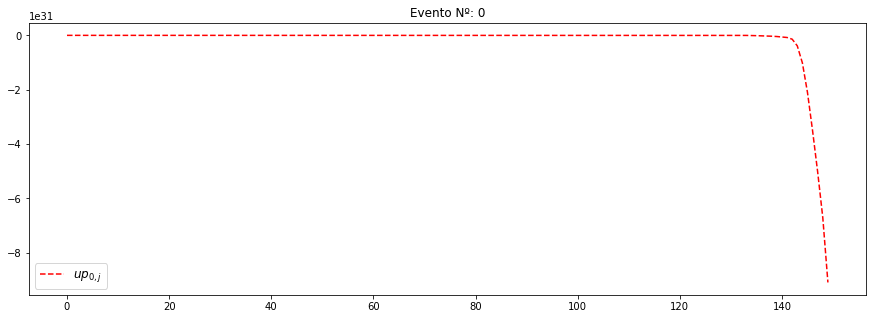

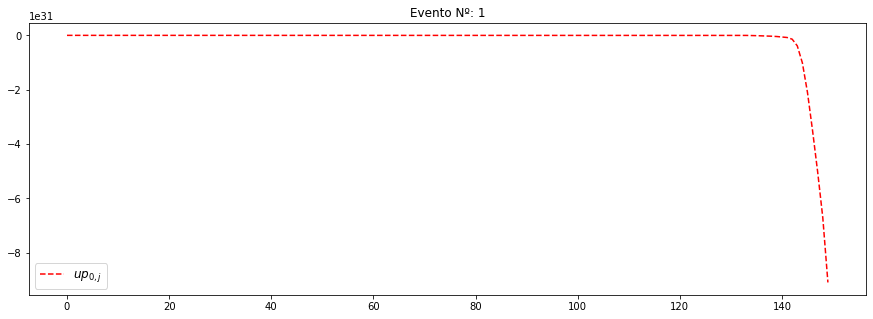

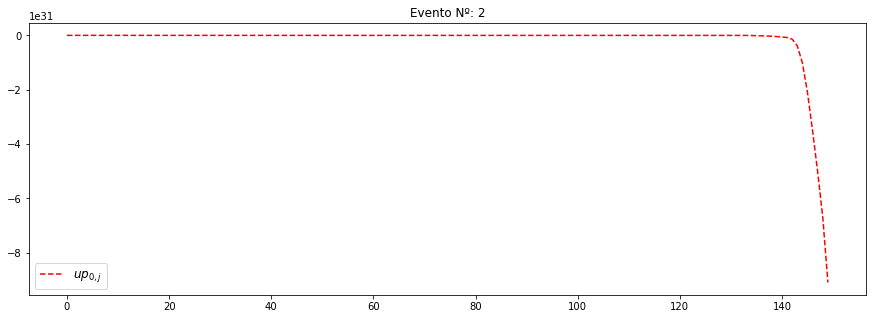

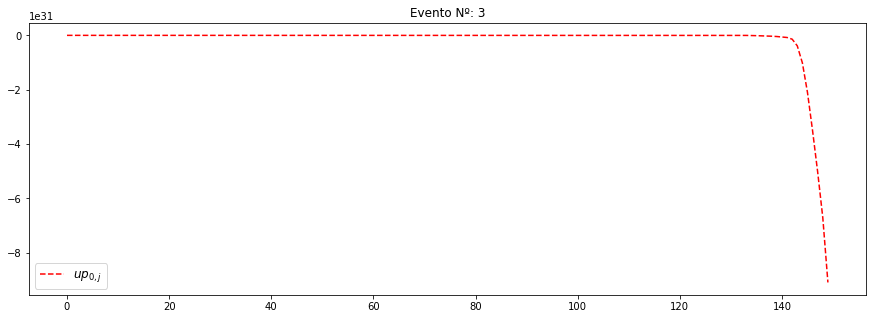

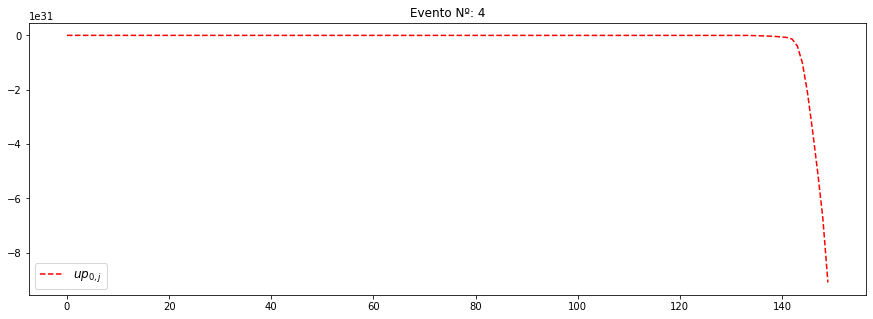

In [18]:
import matplotlib.pyplot as plt

for evento in range(0,5):

    red_input[evento].reshape(301,1)
    up = red_input[evento]
    up_modificado = np.zeros((150,1))

    for j in range(0, int(n_p), 2):
        up_modificado[int(j/2)] = up[j]

    t = np.arange(0., 150., 1)
    
    
    
    plt.figure(figsize=(15,5))
    plt.plot(t,up_modificado , 'r--', c="r", label="$up_{0,j}$")

    plt.legend( prop={'size': 12})
    plt.title(f"Evento Nº: {evento}")
    plt.show()